In [ ]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules
import pickle
import os
import gc

# Load the cleaned transaction list
try:
    with open('../outputs/clean_transactions.pkl', 'rb') as f:
        transaction_list = pickle.load(f)
    print(f"Successfully loaded {len(transaction_list)} baskets.")
except FileNotFoundError:
    print("Error: clean_transactions.pkl not found.")
    exit()

Successfully loaded 297322 baskets.


In [2]:
# Initialize TransactionEncoder
te = TransactionEncoder()

# Transform the list of lists into a one-hot encoded array
te_ary = te.fit(transaction_list).transform(transaction_list)

# Convert the resulting array back to a DataFrame
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# Clean up memory
del te, te_ary, transaction_list
gc.collect()

print(f"One-Hot Encoded Data Shape: {df_encoded.shape}")

One-Hot Encoded Data Shape: (297322, 1302)


In [ ]:
# FP-Growth Execution
# min_support = 0.002 (0.2% of baskets)
# This means an itemset must appear in at least 0.2% of the baskets.

MIN_SUPPORT = 0.002

print(f"\nFinding frequent itemsets with min_support={MIN_SUPPORT}...")

frequent_itemsets = fpgrowth(df_encoded, 
                             min_support=MIN_SUPPORT, 
                             use_colnames=True, 
                             verbose=1)

print(f"\nFound {len(frequent_itemsets)} frequent itemsets.")

# Clean up memory
del df_encoded
gc.collect()

# Display the top 10 most frequent itemsets
print("\nTop 10 Frequent Itemsets:")
print(frequent_itemsets.sort_values(by='support', ascending=False).head(10))


Finding frequent itemsets with min_support=0.002...
905 itemset(s) from tree conditioned on items ()
2 itemset(s) from tree conditioned on items (Extra Virgin Olive Oil)
0 itemset(s) from tree conditioned on items (Extra Virgin Olive Oil, Bag of Organic Bananas)
0 itemset(s) from tree conditioned on items (Extra Virgin Olive Oil, Banana)
10 itemset(s) from tree conditioned on items (Organic Whole Milk)
0 itemset(s) from tree conditioned on items (Organic Whole Milk, Banana)
0 itemset(s) from tree conditioned on items (Organic Whole Milk, Large Lemon)
0 itemset(s) from tree conditioned on items (Organic Whole Milk, Limes)
0 itemset(s) from tree conditioned on items (Organic Whole Milk, Organic Strawberries)
0 itemset(s) from tree conditioned on items (Organic Whole Milk, Bag of Organic Bananas)
0 itemset(s) from tree conditioned on items (Organic Whole Milk, Organic Baby Spinach)
0 itemset(s) from tree conditioned on items (Organic Whole Milk, Organic Avocado)
0 itemset(s) from tree co

In [ ]:
# Association Rule Generation
# min_threshold=0.05 (5% confidence)
MIN_CONFIDENCE = 0.05

print(f"\nGenerating rules with min_confidence={MIN_CONFIDENCE}...")

rules = association_rules(frequent_itemsets, 
                          metric="confidence", 
                          min_threshold=MIN_CONFIDENCE)

# Filter rules to include only those with Lift higher than 1
rules = rules[rules['lift'] > 1]

# Sort rules for business interpretation: highest lift first
rules = rules.sort_values(['lift', 'confidence'], ascending=[False, False])

print(f"Total strong rules generated: {len(rules)}")

# Display the top 10 rules
print("\nTop 10 Strongest Rules (Sorted by Lift):")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))


Generating rules with min_confidence=0.05...
Total strong rules generated: 953

Top 10 Strongest Rules (Sorted by Lift):
                                           antecedents  \
955                         (Non Fat Raspberry Yogurt)   
956    (Icelandic Style Skyr Blueberry Non-fat Yogurt)   
542                       (Vanilla Skyr Nonfat Yogurt)   
543    (Icelandic Style Skyr Blueberry Non-fat Yogurt)   
939  (Total 2% Lowfat Greek Strained Yogurt With Bl...   
938  (Total 2% with Strawberry Lowfat Greek Straine...   
940  (Total 2% Lowfat Greek Strained Yogurt with Pe...   
941  (Total 2% with Strawberry Lowfat Greek Straine...   
874                               (Yellow Bell Pepper)   
873                               (Orange Bell Pepper)   

                                           consequents   support  confidence  \
955    (Icelandic Style Skyr Blueberry Non-fat Yogurt)  0.002398    0.422644   
956                         (Non Fat Raspberry Yogurt)  0.002398    0.360647   

In [5]:
# Filter for rules where the antecedent (left side) has 2 or more items
triplet_rules = rules[rules['antecedents'].apply(lambda x: len(x) >= 2)].copy()

print(f"\nTotal triplet rules (A+B -> C) generated: {len(triplet_rules)}")

# Display the top 5 triplet rules
print("\nTop 5 Triplet Rules (Actionable Bundles):")
print(triplet_rules[['antecedents', 'consequents', 'lift', 'confidence']].head(5))


Total triplet rules (A+B -> C) generated: 66

Top 5 Triplet Rules (Actionable Bundles):
                                      antecedents             consequents  \
275       (Organic Lemon, Bag of Organic Bananas)  (Organic Hass Avocado)   
465                               (Limes, Banana)           (Large Lemon)   
438    (Organic Cucumber, Bag of Organic Bananas)  (Organic Hass Avocado)   
773  (Organic Strawberries, Organic Hass Avocado)   (Organic Raspberries)   
152                     (Banana, Organic Avocado)        (Cucumber Kirby)   

         lift  confidence  
275  5.009975    0.343039  
465  4.950274    0.246347  
438  4.701134    0.321892  
773  4.556672    0.213932  
152  4.469345    0.145690  



Generating visualization of Association Rules...


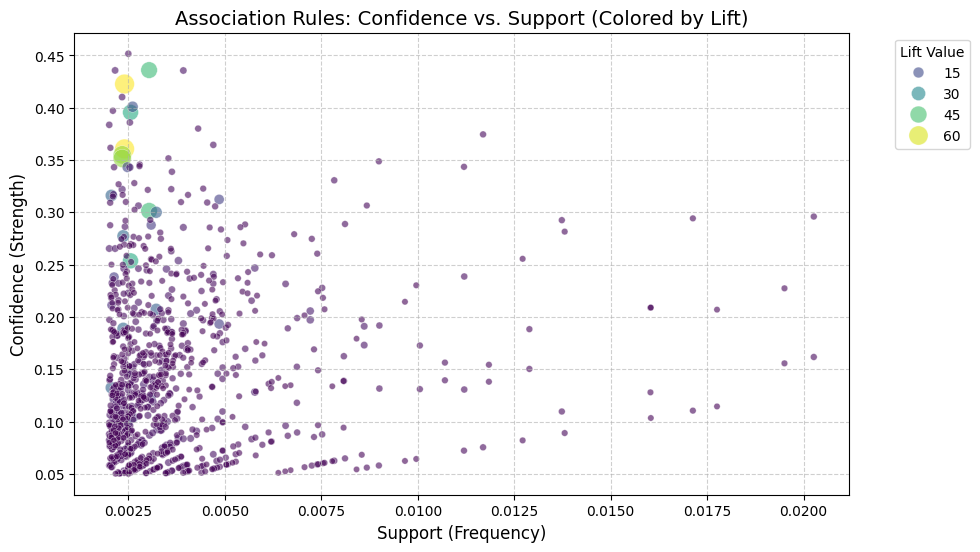

Saved rules visualization to outputs/images/rules_scatter_plot.png


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\nGenerating visualization of Association Rules...")

# Create the plot
plt.figure(figsize=(10, 6))

# Scatter plot: x-axis = Support, y-axis = Confidence, color/size = Lift
sns.scatterplot(
    x="support", 
    y="confidence", 
    size="lift", 
    hue="lift",  
    data=rules,
    palette="viridis", 
    alpha=0.6,
    sizes=(20, 200)
)

# Add titles and labels
plt.title('Association Rules: Confidence vs. Support (Colored by Lift)', fontsize=14)
plt.xlabel('Support (Frequency)', fontsize=12)
plt.ylabel('Confidence (Strength)', fontsize=12)

# Move the legend outside the plot
plt.legend(title="Lift Value", bbox_to_anchor=(1.05, 1), loc=2) 
plt.grid(True, linestyle='--', alpha=0.6)

# Save the plot
plt.savefig('../outputs/images/rules_scatter_plot.png', bbox_inches='tight')
plt.show()

print("Saved rules visualization to outputs/images/rules_scatter_plot.png")

In [7]:
# Save the final ruleset
rules.to_csv('../outputs/association_rules.csv', index=False)
print("\nSaved final association rules to outputs/association_rules.csv")

# Clean up memory
del frequent_itemsets, rules, triplet_rules
gc.collect()


Saved final association rules to outputs/association_rules.csv


685